# Clustering Anomaly Detection Exercises

In [ ]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

## 1. Use DBSCAN to detect anomalies in other products from the customers dataset.

**Acquire the data**

In [24]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [25]:
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")

In [26]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


**Prepare the data**

In [27]:
#Drop Channel and Region
df.drop(["Channel", "Region"], axis = 1, inplace = True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Fresh             440 non-null    int64
 1   Milk              440 non-null    int64
 2   Grocery           440 non-null    int64
 3   Frozen            440 non-null    int64
 4   Detergents_Paper  440 non-null    int64
 5   Delicassen        440 non-null    int64
dtypes: int64(6)
memory usage: 24.1 KB


---

## 1a...Isolate one category of items and used DBSCAN to detect outliers.

In [29]:
#Create the dataframe for frozen items only
frozen_df = df[['Frozen']]

In [30]:
frozen_df.head()

,Frozen
customer_id,
0,214
1,1762
2,2405
3,6404
4,3915


In [31]:
#Create an array of the values and convertto float so that we can scale the values
np_array = frozen_df.values.astype("float32", copy = False)
np_array[0:10]

array([[ 214.],
       [1762.],
       [2405.],
       [6404.],
       [3915.],
       [ 666.],
       [ 480.],
       [1669.],
       [ 425.],
       [1159.]], dtype=float32)

In [32]:
#Create the scaler and fit it
scaler = MinMaxScaler().fit(np_array)

#Transform the scaler so that it can be concatenated to the original dataframe
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.0031063 ],
       [0.02854842],
       [0.03911643],
       [0.1048419 ],
       [0.063934  ],
       [0.01053514],
       [0.00747814],
       [0.02701992],
       [0.00657419],
       [0.01863783]], dtype=float32)

In [33]:
#Create the dbscan object
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(np_array)

# Now, let's add the scaled value columns back onto the dataframe
columns = list(frozen_df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = frozen_df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
frozen_df = frozen_df.merge(scaled_df, on=frozen_df.index)
frozen_df = frozen_df.drop(columns=['key_0'])

labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
frozen_df['labels'] = labels
frozen_df.labels.value_counts()

 0    437
-1      3
Name: labels, dtype: int64

In [35]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(frozen_df.describe())
print("-------------")
print("Inliers")
print(frozen_df[frozen_df.labels==0].describe())
print("-------------")
print("Outliers")
print(frozen_df[frozen_df.labels==-1].describe())

Population
             Frozen  Scaled_Frozen      labels
count    440.000000     440.000000  440.000000
mean    3071.931818       0.050078   -0.006818
std     4854.673333       0.079789    0.082384
min       25.000000       0.000000   -1.000000
25%      742.250000       0.011788    0.000000
50%     1526.000000       0.024670    0.000000
75%     3554.250000       0.058005    0.000000
max    60869.000000       1.000000    0.000000
-------------
Inliers
             Frozen  Scaled_Frozen  labels
count    437.000000     437.000000   437.0
mean    2790.018307       0.045444     0.0
std     3328.832014       0.054711     0.0
min       25.000000       0.000000     0.0
25%      737.000000       0.011702     0.0
50%     1504.000000       0.024308     0.0
75%     3498.000000       0.057080     0.0
max    18711.000000       0.307113     0.0
-------------
Outliers
             Frozen  Scaled_Frozen  labels
count      3.000000       3.000000     3.0
mean   44137.333333       0.725007    -1.0
std  

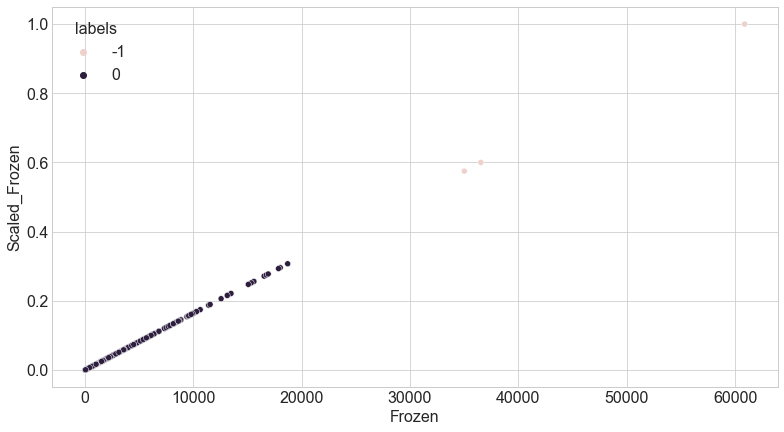

In [36]:
sns.scatterplot(frozen_df.Frozen, frozen_df.Scaled_Frozen, hue=frozen_df.labels)
plt.show()

**Takeaways:**
- With an epsilon of .10, there are 3 outliers in the Frozen Grocery Category
    - One of which, the max of 60869 frozen items is the most extreme and may be an anomaly...

## 1c. Explore Grocery by Detergents_Paper

In [37]:
#Subset the dataframe
grocery_dp = df[['Grocery', 'Detergents_Paper']]
grocery_dp.head()

,Grocery,Detergents_Paper
customer_id,,
0,7561,2674
1,9568,3293
2,7684,3516
3,4221,507
4,7198,1777


In [38]:
#Create an array of the values and convertto float so that we can scale the values
np_array = grocery_dp.values.astype('float32', copy=False)
np_array[0:10]

array([[ 7561.,  2674.],
       [ 9568.,  3293.],
       [ 7684.,  3516.],
       [ 4221.,   507.],
       [ 7198.,  1777.],
       [ 5126.,  1795.],
       [ 6975.,  3140.],
       [ 9426.,  3321.],
       [ 6192.,  1716.],
       [18881.,  7425.]], dtype=float32)

In [39]:
#Create the scaler and fit it
scaler = MinMaxScaler().fit(np_array)

#Scale the data
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.08146416, 0.0654272 ],
       [0.10309667, 0.08058985],
       [0.08278991, 0.08605233],
       [0.04546386, 0.01234568],
       [0.07755155, 0.04345483],
       [0.05521843, 0.04389575],
       [0.07514793, 0.07684205],
       [0.10156612, 0.08127572],
       [0.06670834, 0.04196061],
       [0.20347716, 0.18180482]], dtype=float32)

In [40]:
#Create the dbscan object
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(np_array)

# Now, let's add the scaled value columns back onto the dataframe
columns = list(grocery_dp.columns)
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = grocery_dp.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
grocery_dp = grocery_dp.merge(scaled_df, on=grocery_dp.index)
grocery_dp = grocery_dp.drop(columns=['key_0'])

labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [41]:
grocery_dp['labels'] = labels
grocery_dp.labels.value_counts()

 0    426
-1     14
Name: labels, dtype: int64

In [42]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(grocery_dp.describe())
print("-------------")
print("Inliers")
print(grocery_dp[grocery_dp.labels==0].describe())
print("-------------")
print("Outliers")
print(grocery_dp[grocery_dp.labels==-1].describe())

Population
            Grocery  Detergents_Paper  Scaled_Grocery  \
count    440.000000        440.000000      440.000000   
mean    7951.277273       2881.493182        0.085671   
std     9503.162829       4767.854448        0.102430   
min        3.000000          3.000000        0.000000   
25%     2153.000000        256.750000        0.023174   
50%     4755.500000        816.500000        0.051225   
75%    10655.750000       3922.000000        0.114821   
max    92780.000000      40827.000000        1.000000   

       Scaled_Detergents_Paper      labels  
count               440.000000  440.000000  
mean                  0.070510   -0.031818  
std                   0.116790    0.175716  
min                   0.000000   -1.000000  
25%                   0.006216    0.000000  
50%                   0.019927    0.000000  
75%                   0.095997    0.000000  
max                   1.000000    0.000000  
-------------
Inliers
            Grocery  Detergents_Paper  Scaled_Gr

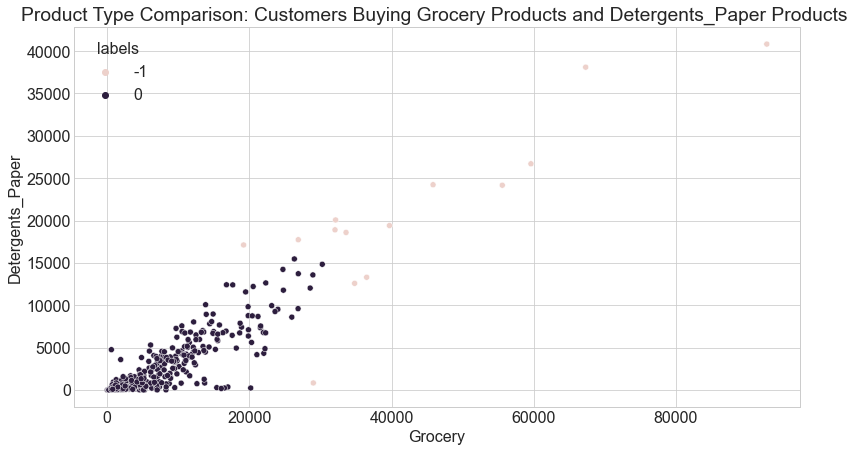

In [43]:
sns.scatterplot(grocery_dp.Grocery, grocery_dp.Detergents_Paper, hue=grocery_dp.labels)
plt.title('Product Type Comparison: Customers Buying Grocery Products and Detergents_Paper Products ')
plt.show()


**Takeaways**
   - Most extreme outlier customer buys Detergents_Paper products at 50% of the grocery products they buy. 
   - No customers are really buying more detergents and paper at alarming rates compared to groceries.

## 1c. Explore Fresh VS Frozen

In [44]:
#Subset the dataframe
fresh_frozen = df[['Fresh', 'Frozen']]
fresh_frozen.head()

,Fresh,Frozen
customer_id,,
0,12669,214
1,7057,1762
2,6353,2405
3,13265,6404
4,22615,3915


In [45]:
#Create an array of the values and convertto float so that we can scale the values
np_array = fresh_frozen.values.astype('float32', copy = False)
np_array[0:10]

array([[12669.,   214.],
       [ 7057.,  1762.],
       [ 6353.,  2405.],
       [13265.,  6404.],
       [22615.,  3915.],
       [ 9413.,   666.],
       [12126.,   480.],
       [ 7579.,  1669.],
       [ 5963.,   425.],
       [ 6006.,  1159.]], dtype=float32)

In [46]:
#Create the scaler and fit it
scaler = MinMaxScaler().fit(np_array)

#Scale the data
np_array = scaler.transform(np_array)

In [47]:
np_array[0:10]

array([[0.11294005, 0.0031063 ],
       [0.06289903, 0.02854842],
       [0.05662161, 0.03911643],
       [0.11825445, 0.1048419 ],
       [0.20162643, 0.063934  ],
       [0.08390699, 0.01053514],
       [0.10809823, 0.00747814],
       [0.06755359, 0.02701992],
       [0.05314406, 0.00657419],
       [0.05352748, 0.01863783]], dtype=float32)

In [48]:
#Create the dbscan object
dbsc = DBSCAN(eps = .05, min_samples = 20).fit(np_array)

# Now, let's add the scaled value columns back onto the dataframe
columns = list(fresh_frozen.columns)
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = fresh_frozen.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
fresh_frozen = fresh_frozen.merge(scaled_df, on=fresh_frozen.index)
fresh_frozen = fresh_frozen.drop(columns=['key_0'])

labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [49]:
fresh_frozen['labels'] = labels
fresh_frozen.labels.value_counts()

 0    391
-1     49
Name: labels, dtype: int64

In [50]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(fresh_frozen.describe())
print("-------------")
print("Inliers")
print(fresh_frozen[fresh_frozen.labels==0].describe())
print("-------------")
print("Outliers")
print(fresh_frozen[fresh_frozen.labels==-1].describe())

Population
               Fresh        Frozen  Scaled_Fresh  Scaled_Frozen      labels
count     440.000000    440.000000    440.000000     440.000000  440.000000
mean    12000.297727   3071.931818      0.106977       0.050078   -0.111364
std     12647.328865   4854.673333      0.112774       0.079789    0.314940
min         3.000000     25.000000      0.000000       0.000000   -1.000000
25%      3127.750000    742.250000      0.027863       0.011788    0.000000
50%      8504.000000   1526.000000      0.075802       0.024670    0.000000
75%     16933.750000   3554.250000      0.150968       0.058005    0.000000
max    112151.000000  60869.000000      1.000000       1.000000    0.000000
-------------
Inliers
              Fresh        Frozen  Scaled_Fresh  Scaled_Frozen  labels
count    391.000000    391.000000    391.000000     391.000000   391.0
mean    9135.549872   2091.654731      0.081433       0.033966     0.0
std     7613.542917   2087.972887      0.067888       0.034317     0.0

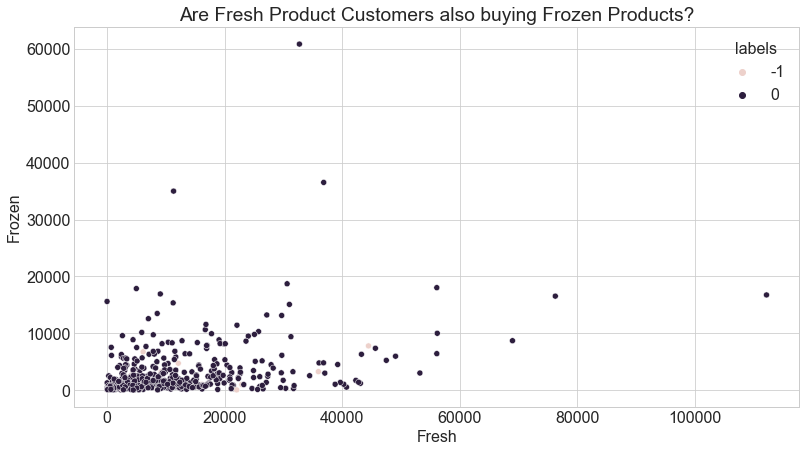

In [51]:
sns.scatterplot(fresh_frozen.Fresh, fresh_frozen.Frozen, hue=grocery_dp.labels)
plt.title('Are Fresh Product Customers also buying Frozen Products?')
plt.show()

In [52]:
fresh_frozen[fresh_frozen.labels==-1].sample(10)

,Fresh,Frozen,Scaled_Fresh,Scaled_Frozen,labels
103,56082,18028,0.500045,0.295888,-1
124,36050,4787,0.321423,0.078266,-1
70,16705,10643,0.148928,0.174512,-1
381,17770,9927,0.158425,0.162744,-1
325,32717,60869,0.291704,1.000000,-1
310,7034,12569,0.062694,0.206167,-1
435,29703,13135,0.264829,0.215469,-1
425,11243,15348,0.100225,0.251841,-1
176,45640,7368,0.406935,0.120686,-1
431,8533,13486,0.076060,0.221238,-1


**Takeaways:**
    - Not much here.

---

## 2. Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

**Data Acquisition**

In [53]:
url = get_db_url("zillow")

sql = """
SELECT prop.parcelid, 
                    prop.bathroomcnt, 
                    prop.bedroomcnt, 
                    prop.calculatedbathnbr, 
                    prop.calculatedfinishedsquarefeet, 
                    prop.fips,
                    prop.latitude,
                    prop.longitude,  
                    prop.structuretaxvaluedollarcnt, 
                    prop.taxvaluedollarcnt, 
                    prop.landtaxvaluedollarcnt, 
                    prop.taxamount, 
                    prop.propertylandusetypeid,
                    proptype.propertylandusedesc
            FROM properties_2017 as prop
            JOIN predictions_2017 as pred USING(parcelid)
            JOIN propertylandusetype as proptype USING(propertylandusetypeid)
            WHERE (pred.transactiondate between '2017-05-01'
							AND '2017-08-31')
					AND (prop.propertylandusetypeid IN (260, 261, 262, 263, 264,
                                                         268, 269, 273, 274, 275, 276, 279))
"""

df = pd.read_sql(sql, url)

In [54]:
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,latitude,longitude,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,propertylandusetypeid,propertylandusedesc
0,11721753,2.0,3.0,2.0,1316.0,6037.0,34033180.0,-118355396.0,41948.0,205123.0,163175.0,2627.48,261.0,Single Family Residential
1,11289917,2.0,3.0,2.0,1458.0,6037.0,34686163.0,-118113100.0,108890.0,136104.0,27214.0,2319.90,261.0,Single Family Residential
2,11705026,1.0,2.0,1.0,1421.0,6037.0,33999877.0,-118291863.0,11982.0,35606.0,23624.0,543.69,261.0,Single Family Residential
3,14269464,3.0,4.0,3.0,2541.0,6059.0,33694636.0,-117912245.0,434887.0,880456.0,445569.0,9819.72,261.0,Single Family Residential
4,11446756,2.0,3.0,2.0,1491.0,6037.0,33873860.0,-118338253.0,60537.0,107110.0,46573.0,1399.27,261.0,Single Family Residential


In [55]:
#Rename columns
df.rename(columns={'calculatedfinishedsquarefeet': 'sqft'}, inplace=True)

In [56]:
df = df.dropna(axis=0)

In [57]:
#Subset the dataframe and preview 
bedrooms_sqft = df[['bedroomcnt', 'sqft']]
bedrooms_sqft.head()

,bedroomcnt,sqft
0,3.0,1316.0
1,3.0,1458.0
2,2.0,1421.0
3,4.0,2541.0
4,3.0,1491.0


In [58]:
#bedrooms_sqft.dropna(axis=0,inplace=True)

In [59]:
bedrooms_sqft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29123 entries, 0 to 29270
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bedroomcnt  29123 non-null  float64
 1   sqft        29123 non-null  float64
dtypes: float64(2)
memory usage: 682.6 KB


In [60]:
#Create an array of the values and convert to float so that we can scale the values
np_array= bedrooms_sqft.values.astype('float32', copy = False)
np_array[0:10]

array([[3.000e+00, 1.316e+03],
       [3.000e+00, 1.458e+03],
       [2.000e+00, 1.421e+03],
       [4.000e+00, 2.541e+03],
       [3.000e+00, 1.491e+03],
       [3.000e+00, 1.650e+03],
       [2.000e+00, 6.930e+02],
       [4.000e+00, 1.655e+03],
       [3.000e+00, 1.331e+03],
       [3.000e+00, 1.440e+03]], dtype=float32)

In [61]:
len(np_array)

29123

In [62]:
#Create the scaler and fit it
scaler= MinMaxScaler().fit(np_array)

#Scale the data
np_array= scaler.transform(np_array)

np_array[0:10]

array([[0.25      , 0.06327551],
       [0.25      , 0.07162599],
       [0.16666667, 0.06945016],
       [0.33333334, 0.13531314],
       [0.25      , 0.0735666 ],
       [0.25      , 0.08291679],
       [0.16666667, 0.02663922],
       [0.33333334, 0.08321082],
       [0.25      , 0.06415761],
       [0.25      , 0.07056748]], dtype=float32)

In [63]:
len(np_array)

29123

In [64]:
#Create the dbscan object
dbsc = DBSCAN(eps = .1, min_samples = 20).fit(np_array)

# Now, let's add the scaled value columns back onto the dataframe
columns = list(bedrooms_sqft.columns)
scaled_columns = ["Scaled_" + column for column in columns]

In [65]:
scaled_columns

['Scaled_bedroomcnt', 'Scaled_sqft']

In [66]:
# Save a copy of the original dataframe
original_df = bedrooms_sqft.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

In [67]:
scaled_df.set_index(bedrooms_sqft.index)

,Scaled_bedroomcnt,Scaled_sqft
0,0.250000,0.063276
1,0.250000,0.071626
2,0.166667,0.069450
3,0.333333,0.135313
4,0.250000,0.073567
...,...,...
29266,0.416667,0.127727
29267,0.333333,0.055690
29268,0.416667,0.163187
29269,0.416667,0.161835


In [68]:
bedrooms_sqft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29123 entries, 0 to 29270
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bedroomcnt  29123 non-null  float64
 1   sqft        29123 non-null  float64
dtypes: float64(2)
memory usage: 682.6 KB


In [69]:
# Merge the scaled and non-scaled values into one dataframe
bedrooms_sqft= bedrooms_sqft.merge(scaled_df, on=bedrooms_sqft.index)

In [70]:
bedrooms_sqft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29123 entries, 0 to 29122
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key_0              29123 non-null  int64  
 1   bedroomcnt         29123 non-null  float64
 2   sqft               29123 non-null  float64
 3   Scaled_bedroomcnt  29123 non-null  float32
 4   Scaled_sqft        29123 non-null  float32
dtypes: float32(2), float64(2), int64(1)
memory usage: 1.1 MB


In [71]:
bedrooms_sqft= bedrooms_sqft.drop(columns=['key_0'])

In [72]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [73]:
bedrooms_sqft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29123 entries, 0 to 29122
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedroomcnt         29123 non-null  float64
 1   sqft               29123 non-null  float64
 2   Scaled_bedroomcnt  29123 non-null  float32
 3   Scaled_sqft        29123 non-null  float32
dtypes: float32(2), float64(2)
memory usage: 910.1 KB


In [74]:
bedrooms_sqft.head()

,bedroomcnt,sqft,Scaled_bedroomcnt,Scaled_sqft
0,3.0,1316.0,0.250000,0.063276
1,3.0,1458.0,0.250000,0.071626
2,2.0,1421.0,0.166667,0.069450
3,4.0,2541.0,0.333333,0.135313
4,3.0,1491.0,0.250000,0.073567


In [75]:
len(labels)

29123

In [76]:
bedrooms_sqft.head()

,bedroomcnt,sqft,Scaled_bedroomcnt,Scaled_sqft
0,3.0,1316.0,0.250000,0.063276
1,3.0,1458.0,0.250000,0.071626
2,2.0,1421.0,0.166667,0.069450
3,4.0,2541.0,0.333333,0.135313
4,3.0,1491.0,0.250000,0.073567


In [77]:
bedrooms_sqft['labels'] = labels
bedrooms_sqft.labels.value_counts()

 0    29105
-1       18
Name: labels, dtype: int64

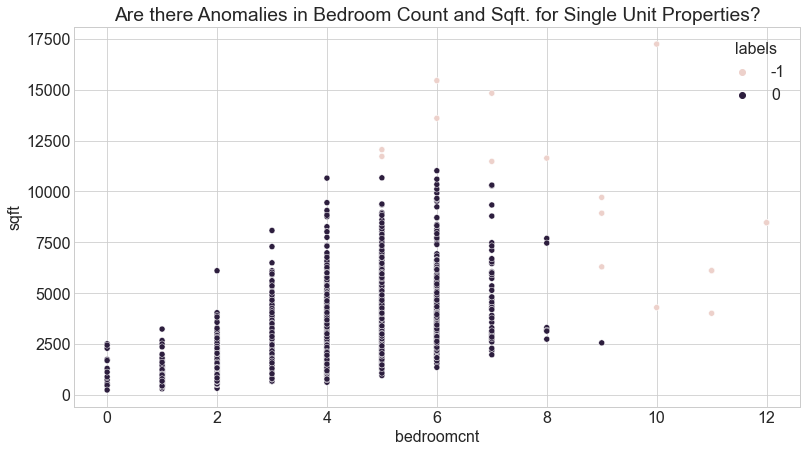

In [78]:
sns.scatterplot(bedrooms_sqft.bedroomcnt, bedrooms_sqft.sqft,   hue=bedrooms_sqft.labels)
plt.title('Are there Anomalies in Bedroom Count and Sqft. for Single Unit Properties?')
plt.show()

**Takeaways:**
   - What are the properties where the bedroomcnt is 11 and the square footage is low? That doesn't make much sense...

---

## 3. Use DBSCAN to detect anomalies in curriculum logs

In [3]:
import acquire

In [4]:
df = acquire.get_curriculum_logs()
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0


In [5]:
import prepare

In [6]:
df = prepare.prep_access_logs(df)
df.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at
dt,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10


In [7]:
#Create a column that calculates how many days have passed since the program end date for each curriculum log access observation
df['time_since_program_end'] = (df.index - df.end_date) // pd.Timedelta('1d')

In [8]:
alumni_logs = df[df.time_since_program_end > 0]

In [9]:
alumni_logs.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,time_since_program_end
dt,,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,720.0
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,720.0
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,720.0
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,720.0
2018-01-26 10:14:47,/,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1375.0


In [10]:
user_time_since_grad = alumni_logs[["user_id", "time_since_program_end"]]

In [11]:
user_time_since_grad = user_time_since_grad.groupby('user_id').max('time_since_program_end')

In [12]:
user_time_since_grad=user_time_since_grad.reset_index()

In [15]:
#Create an array of the values and convert to float so that we can scale the values
np_array= user_time_since_grad.values.astype('float32', copy = False)
np_array[0:10]

array([[1.000e+00, 2.633e+03],
       [3.000e+00, 3.240e+02],
       [5.000e+00, 6.300e+01],
       [6.000e+00, 3.050e+02],
       [7.000e+00, 4.060e+02],
       [1.000e+01, 9.380e+02],
       [1.100e+01, 2.633e+03],
       [1.200e+01, 8.720e+02],
       [1.300e+01, 1.046e+03],
       [1.400e+01, 1.460e+02]], dtype=float32)

In [16]:
#Create the scaler and fit it
scaler= MinMaxScaler().fit(np_array)

#Scale the data
np_array= scaler.transform(np_array)

np_array[0:10]

array([[0.        , 1.        ],
       [0.0020429 , 0.12238692],
       [0.0040858 , 0.0231851 ],
       [0.00510725, 0.11516534],
       [0.0061287 , 0.15355378],
       [0.00919305, 0.35575828],
       [0.0102145 , 1.        ],
       [0.01123596, 0.33067274],
       [0.01225741, 0.3968073 ],
       [0.01327886, 0.05473204]], dtype=float32)

In [17]:
#Create the dbscan object
dbsc = DBSCAN(eps = .1, min_samples = 20).fit(np_array)

# Now, let's add the scaled value columns back onto the dataframe
columns = list(user_time_since_grad.columns)
scaled_columns = ["Scaled_" + column for column in columns]

In [18]:
# Save a copy of the original dataframe
original_df = user_time_since_grad.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

In [19]:
# Merge the scaled and non-scaled values into one dataframe
user_time_since_grad= user_time_since_grad.merge(scaled_df, on=user_time_since_grad.index)

In [20]:
user_time_since_grad= user_time_since_grad.drop(columns=['key_0'])

In [21]:
labels = dbsc.labels_
labels[0:10]

array([-1,  0,  0,  0,  0,  0, -1,  0,  0,  0])

In [22]:
user_time_since_grad['labels'] = labels
user_time_since_grad.labels.value_counts()

 0    500
-1     92
Name: labels, dtype: int64

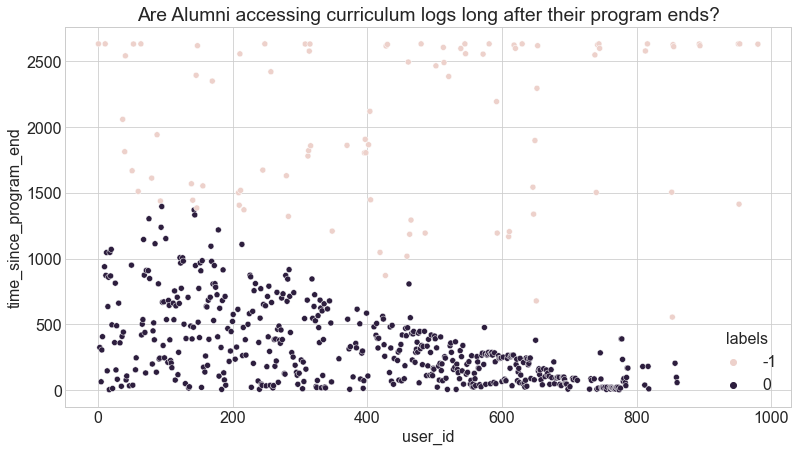

In [23]:
sns.scatterplot(user_time_since_grad.user_id, user_time_since_grad.time_since_program_end,   hue=user_time_since_grad.labels)
plt.title('Are Alumni accessing curriculum logs long after their program ends?')
plt.show()

**Takeaways:**
   - Too much noise here...should filter by co-hort to reduce noise and process takeaways